# Random Effect Logistic Regression by MLMC Variational Bayes

## Model Description

##### Random Effect Models:
For $n=1,2,...$,
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Z_n \sim N(0,\tau^2)$
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t})}\right)$
<br>
for $t=1, ..., T$. This model carries out dimentionality reduction of binary observations $y_{n,k}$'s. Here, the dimention of $\beta$ and $x_{n,t}$ is $D$.<br>
As variational approximation of the posterior $p(z_n|y_n)$, we use $q(z_n)= N(z_n;\mu_n, \sigma_n^2)$.

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

##### Possible Extension:

By adding $\bar x_n=\frac{1}{T}\sum_t x_{n,t}$ to the predictors as 
<br>&nbsp;&nbsp;&nbsp;&nbsp;
$Y_{n,t} \sim \text{Bernoulli}\left(\frac{1}{1+\exp(- Z_n - \beta_0 - \beta^T x_{n,t}- \gamma\bar x_n)}\right)$,
<br>
we can obtain correlated random effect models.

#### We do not consider the use of Renyi divergences

## Import Packages

In [1]:
# Turn GPUs off
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import pandas as pd
from scipy.stats import bernoulli, norm
from matplotlib import pyplot as plt
import time
np.random.seed(0)

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Utilities

In [4]:
sigmoid = lambda x: 1/(1+np.exp(-x))
softplus = lambda x: np.log(1+np.exp(x))
as_tf_float = lambda x: tf.cast(x, tf.float64)

def tf_logsumexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims)

def tf_logmeanexp(ary, axis=1, keepdims=False):
    return tf.math.reduce_logsumexp(ary, axis=axis, keepdims=keepdims) \
        - tf.math.log(as_tf_float(ary.shape[axis]))

## Generate Toy Dataset

In [5]:
N = 1000
D = 3
T = 2

In [6]:
# data
# We assume that we have infinite amount of data.
# Thus, generator of the data is implemented.
def generate_data(N, D, T, beta0, beta, alpha):
    z = np.random.randn(N) * softplus(alpha)**(1/2.)
    x = np.random.randn(N*T*D).reshape([N,T,D])
    y = bernoulli(p=sigmoid(beta0+x@beta+z.reshape([N,1]))).rvs()
    return x,y,z

To constrain the parameter $\tau^2>0$, we parametrize $\tau^2$ as $\tau^2 = \mathrm{softplus}(\alpha)$, where $\mathrm{softplus}(x) := \log(1+\exp(x))>0$.

In [7]:
# paramters
alpha = np.float64(1.)
beta0 = np.float64(0.)
beta  = np.array([0.25, 0.50, 0.75]) #np.random.randn(D) / np.sqrt(D)
param0 = {
    'alpha': alpha,
    'beta0': beta0,
    'beta': beta
}

In [8]:
x,y,z = generate_data(N, D, T, beta0, beta, alpha)

## Sigmoid Normal Integral Approximation of Evidence

Ref: Barber Bishop(1998), PRML(2006)

In [9]:
def sigmoid_normal_prob(x, beta0, beta, alpha):
    N, T, D  = x.shape
    kappa = 1 / (1 + np.pi*tf.math.softplus(alpha)/8)**(1/2)
    return tf.math.sigmoid( kappa * (beta0 + tf.reshape( x@tf.reshape(beta, [D,1]), [N, T])) )

In [10]:
def sigmoid_normal_likelihood(x, y, beta0, beta, alpha):
    pred_prob = sigmoid_normal_prob(x, beta0, beta, alpha)
    score = tf.reduce_mean(tf.reduce_sum(
        tf.math.log(pred_prob)*y + tf.math.log(1-pred_prob)*(1-y), 
        axis=1))
    return score

## Laplace Approximation of Posterior

In [11]:
def laplace_approx(x, y, beta0, beta, alpha):
    N, T, D  = x.shape
    z = np.zeros([N, 1])
    _sig = lambda z: sigmoid( z + beta0 + x@beta )
    for i in range(10):
        sig = _sig(z)
        hessian = 1/softplus(alpha) + np.sum( sig*(1-sig), axis=1, keepdims=True)
        grad    = z/softplus(alpha) + np.sum( sig - y,     axis=1, keepdims=True)
        z -= grad / hessian
    mu = z.reshape([N])
    sigma = (1 / hessian).reshape([N])**(1/2)
    return mu, sigma

In [12]:
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)

In [13]:
z.var(), (z-mu).var()

(1.2794247861348982, 0.8693498990847699)

## IWELBO approximation of Evidence

In [14]:
def pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    """
    Compute IWELBOs for i = 1,...,n using n_MC samples Zn. 
    Here, we assume that n<N where N is the size of data.
    
    Arguments:
    x: 3-d array of size [N, T, D]
    y: 2-d array of size [N, T]
    z: 1-d array of size [n_MC, N]
    beta: 1-d array of size [D]
    mu: 1-d array of [N]
    sigma**2: 1-d array of [N]
    
    Returns:
    iwelbo: iwelbo, whose size is [N]
    """

    (N, T, D), (n_MC, n) = x.shape, z.shape
    y = as_tf_float( tf.reshape(y, [1,N,T]) )
    mu = tf.reshape(mu, [1,N])
    sigma = tf.reshape(sigma, [1,N])
    
    y_logits = tf.convert_to_tensor( beta0\
                                    + tf.reshape( x@tf.reshape(beta, [D,1]), [1, N, T])\
                                    + tf.reshape(z, [n_MC, N, 1]) 
                                   )
    p_y = tfp.distributions.Bernoulli(logits=y_logits)
    p_z = tfp.distributions.Normal(loc=np.zeros([1, N]), scale=tf.math.softplus(alpha)**(1/2.))
    q_z = tfp.distributions.Normal(loc=mu, scale=sigma)
    
    log_prob_ratio = \
        tf.reduce_sum( p_y.log_prob(y), axis=2)\
        + p_z.log_prob(z)\
        - q_z.log_prob(z)
    
    iwelbo = tf_logmeanexp(log_prob_ratio, axis=0)
    return iwelbo

In [15]:
def IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC):
    N, = mu.shape
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    iwelbo = tf.reduce_mean( pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return iwelbo

In [16]:
signorm_likelihood = sigmoid_normal_likelihood(x, y, beta0, beta, alpha).numpy()
elbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1).numpy()
iwelbo_likelihood = IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64).numpy()

In [17]:
signorm_likelihood, elbo_likelihood, iwelbo_likelihood

(-1.2678174292543385, -1.2533704963197403, -1.2516794807611216)

## Maximum Likelihood by Different Approximation

In [18]:
objectives = {
    "signorm": lambda beta0, beta, alpha, mu, sigma: sigmoid_normal_likelihood(x, y, beta0, beta, alpha),
    "elbo": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=1),
    "iwelbo8": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=8),
    "iwelbo64": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64),
    "iwelbo512": lambda beta0, beta, alpha, mu, sigma: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=512)
}
params = {"ground_truth": param0}

N,T,D = (1000, 2, 3) if tf.test.is_gpu_available() else (200, 2, 3)

for obj_name, obj_func in objectives.items():
    
    print("training {}...".format(obj_name))
    
    beta0_ = tf.Variable(0., dtype=tf.float64)
    beta_  = tf.Variable(np.zeros([D]), dtype=tf.float64)
    alpha_   = tf.Variable(1., dtype=tf.float64)
    
    # Gradient Descent
    for t in range(2001):
        
        rho_t = 0.5/(1+t)**0.7
        x,y,_ = generate_data(N, D, T, beta0, beta, alpha)

        with tf.GradientTape() as g:
            g.watch([beta0_, beta_, alpha_])
            mu, sigma = laplace_approx(x, y, beta0_.numpy(), beta_.numpy(), alpha_.numpy())
            score = obj_func(beta0_, beta_, alpha_, mu, sigma)
        dbeta0_, dbeta_, dalpha_ = g.gradient(score, [beta0_, beta_, alpha_])

        beta0_ = beta0_ + rho_t*dbeta0_
        beta_ = beta_ + rho_t*dbeta_
        alpha_ = alpha_ + dalpha_
        if t%200==0:
            print("#iter: {},\tloss: {}".format(t, -score.numpy()))
    
    params[obj_name] = {
        'alpha': alpha_.numpy(),
        'beta0': beta0_.numpy(),
        'beta': beta_.numpy()
    }
    print()

training signorm...
#iter: 0,	loss: 1.3862943611198906
#iter: 200,	loss: 1.2663498098398245
#iter: 400,	loss: 1.2557613690364071
#iter: 600,	loss: 1.2786190640351738
#iter: 800,	loss: 1.263393567260694
#iter: 1000,	loss: 1.2503647850477055
#iter: 1200,	loss: 1.256146279426635
#iter: 1400,	loss: 1.301404761107472
#iter: 1600,	loss: 1.2827542198918744
#iter: 1800,	loss: 1.2635394911318214
#iter: 2000,	loss: 1.2687927989126437

training elbo...
#iter: 0,	loss: 1.3755441785959754
#iter: 200,	loss: 1.2434198012540225
#iter: 400,	loss: 1.2477401340996659
#iter: 600,	loss: 1.2637521420966198
#iter: 800,	loss: 1.2748003658452591
#iter: 1000,	loss: 1.2685422739669239
#iter: 1200,	loss: 1.249414001563846
#iter: 1400,	loss: 1.2624448620019175
#iter: 1600,	loss: 1.241196447846655
#iter: 1800,	loss: 1.267591244312262
#iter: 2000,	loss: 1.2456771036647196

training iwelbo8...
#iter: 0,	loss: 1.3787175094382007
#iter: 200,	loss: 1.2427806806771182
#iter: 400,	loss: 1.2357086281734486
#iter: 600,	loss

In [19]:
def expand(key, val):
    # expand {"name":array([1,2,3,4,5])}
    # into {"name1":1, "name2":2, ..., "name5":5}
    if type(val)==np.ndarray:
        return {key+str(i+1): x for i,x in enumerate(val)} 
    else:
        return {key:val} 

def expand_param(param):
    expanded_param = {}
    for key, val in param.items():
        expanded_param.update(expand(key,val))
    return expanded_param

In [20]:
pd.DataFrame({key: expand_param(param) for key,param in params.items()}).T

,alpha,beta0,beta1,beta2,beta3
ground_truth,1.000000,0.000000,0.250000,0.500000,0.750000
signorm,-0.265774,-0.000384,0.219535,0.441023,0.662330
elbo,-0.298286,0.001714,0.220300,0.442042,0.659013
iwelbo8,0.533870,0.001106,0.235486,0.470319,0.706195
iwelbo64,0.872774,-0.001154,0.239646,0.476879,0.721607
iwelbo512,0.918201,0.000414,0.239296,0.480750,0.722587


##### Bottom Line: IWELBO gives better estiamte than elbo or sigmoid normal integral approximation, even for simple this model. 

## MLMC

In [21]:
def pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma):
    
    (N, T, D), (n_MC, N) = x.shape, z.shape
    assert np.log2(n_MC)%1==0
    
    if n_MC == 1:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
    else:
        scores = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[:n_MC//2 ], beta0, beta, alpha, mu, sigma)
        scores -= (1/2.) * pointwise_IWELBO(x, y, z[ n_MC//2:], beta0, beta, alpha, mu, sigma)
    return scores

In [22]:
def dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbo = tf.reduce_mean( pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma) )
    return diwelbo

In [23]:
def IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=8, w0=1-2.**(-3/2), b=2, randomize=False):
    
    N, T, D = x.shape
    
    if max_level==0:
        levels = np.array([0])
        weights = np.array([1.])
    else:
        levels = np.arange(max_level)
        weights = 2.**(-(b+1)/2*levels)
        weights /= sum(weights)
        weights = np.concatenate([[w0], (1-w0)*weights])
    
    if randomize==True:
         Ns = np.random.multinomial(n=N, pvals=weights)    
    elif randomize==False:
        Ns = np.zeros_like(levels)
        Ns = np.array([np.math.ceil(w*N) for w in weights], dtype=np.int)
        Ns[0] = N - sum(Ns[1:])
    else:
        raise(Exception("Invarid argument for 'randomize' of function IWELBO_MLMC. It must be True or False."))
    
    N_offset = 0
    score = 0
    for i, l in enumerate(levels):
        if Ns[i]==0:
            continue
        x_tmp = x[N_offset:N_offset+Ns[i]]
        y_tmp = y[N_offset:N_offset+Ns[i]]
        mu_tmp = mu[N_offset:N_offset+Ns[i]]
        sigma_tmp = sigma[N_offset:N_offset+Ns[i]]
                       
        if randomize==True:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l) * Ns[i] / N / weights[i]   
        elif randomize==False:
            score += dIWELBO(x_tmp, y_tmp, beta0, beta, alpha, mu_tmp, sigma_tmp, level=l)
        
        N_offset += Ns[i]
    return score

In [24]:
x,y,_ = generate_data(N=10000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    

In [25]:
IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=6, w0=0.9, randomize=True)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.2489282963822315>

In [26]:
IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=64)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.252667339263103>

## MLMC codition check for objective

In [27]:
def conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N])
    
    diwelbos = pointwise_dIWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    iwelbos = pointwise_IWELBO(x, y, z, beta0, beta, alpha, mu, sigma).numpy()
    
    return {'mean_dIWELBO':np.mean(diwelbos), 
            'mean_abs_dIWELBO':np.mean(np.abs(diwelbos)), 
            'mean_squared_dIWELBO':np.mean(diwelbos**2),
            'var_dIWELBO':np.var(diwelbos), 
            'var_IWELBO':np.var(iwelbos)}

In [28]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

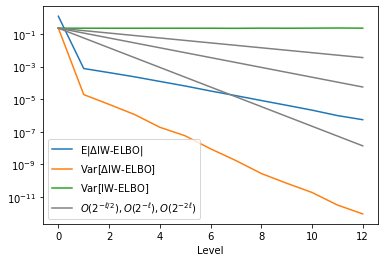

In [29]:
plt.plot(conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO', 'var_IWELBO']])
s,t = conv_stats[['mean_abs_dIWELBO', 'var_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$\mathrm{E} | \Delta \mathrm{IW}$-$\mathrm{ELBO}|$', 
            r'$\mathrm{Var}[\Delta \mathrm{IW}$-$\mathrm{ELBO}]$', 
            r'$\mathrm{Var}[\mathrm{IW}$-$\mathrm{ELBO}]$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [30]:
conv_stats

,mean_dIWELBO,mean_abs_dIWELBO,mean_squared_dIWELBO,var_dIWELBO,var_IWELBO
0,-1.251808e+00,1.251856e+00,1.798832e+00,2.318080e-01,0.231808
1,7.716680e-04,7.716680e-04,1.996632e-05,1.937085e-05,0.231087
2,4.326944e-04,4.326944e-04,5.035159e-06,4.847935e-06,0.229596
3,2.395057e-04,2.395057e-04,1.223949e-06,1.166586e-06,0.229664
4,1.247269e-04,1.247269e-04,2.065863e-07,1.910295e-07,0.230627
5,6.537905e-05,6.537905e-05,6.114108e-08,5.686666e-08,0.230472
6,3.223186e-05,3.223186e-05,1.012881e-08,9.089912e-09,0.230340
7,1.664210e-05,1.664210e-05,1.998229e-09,1.721269e-09,0.226672
8,8.403741e-06,8.403741e-06,3.479621e-10,2.773393e-10,0.232396
9,4.270277e-06,4.270277e-06,8.810907e-11,6.987381e-11,0.229618


## MLMC codition check for gradients

In [31]:
def conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=1):
    
    N, = mu.shape
    n_MC = 2**level
    z = norm(loc=mu, scale=sigma).rvs([n_MC, N]).T
    
    param = tf.concat([beta, [beta0], [alpha]], axis=0)
    param = tf.Variable(param, dtype=tf.float64)
    params = tf.reshape(param, [1,D+2]) * np.ones([N,1])

    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)        
    
    def get_grad(args):
        
        param, x_, y_, z_, mu, sigma = args
        z_ = tf.reshape(z_, [-1,1])
        
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[0,:D]
            beta0_ = param[0,D]
            alpha_ = param[0,D+1]
            diwelbos = pointwise_dIWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            iwelbos = pointwise_IWELBO(x_, y_, z_, beta0_, beta_, alpha_, mu, sigma)
            
        a = g.gradient(diwelbos, param)
        b = g.gradient(iwelbos, param)
        
        del g
        
        return a,b
    
    args = [tf.expand_dims(arg, axis=1) for arg in [params, x, y, z, mu, sigma]]
    grads = tf.vectorized_map(get_grad, args)
    
    grad_diwelbos = tf.squeeze(grads[0])#[:D+1]
    grad_iwelbos = tf.squeeze(grads[1])#[:D+1]
    
    return {'norm_mean_grad_dIWELBO': np.linalg.norm(np.mean(grad_diwelbos, axis=0)), 
            'mean_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)), 
            'mean_squared_norm_grad_dIWELBO': np.mean(np.linalg.norm(grad_diwelbos, axis=1)**2),
            'trace_covariance_grad_dIWELBO': np.sum(np.var(grad_diwelbos, axis=0)), 
            'trace_covariance_grad_IWELBO': np.sum(np.var(grad_iwelbos, axis=0))}

In [32]:
def tmp(l):
    N0 = 2000000
    x,y,_ = generate_data(N=N0//2**l, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
    return conv_stats_grad_dIWELBO(x, y, beta0, beta, alpha, mu, sigma, level=l)
L=13
conv_stats = [tmp(l) for l in range(L)]
conv_stats = pd.DataFrame(conv_stats)

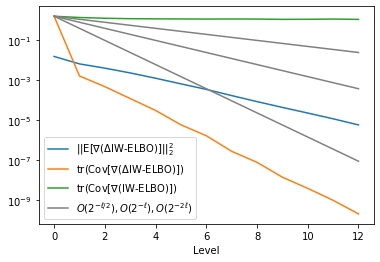

In [33]:
plt.plot(conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO', 'trace_covariance_grad_IWELBO']])
s,t = conv_stats[['norm_mean_grad_dIWELBO', 'trace_covariance_grad_dIWELBO']].iloc[0]
plt.plot(t*2.**(-np.arange(L)/2), c='grey')
plt.plot(t*2.**(-np.arange(L)), c='grey')
plt.plot(t*2.**(-np.arange(L)*2), c='grey')

plt.legend([r'$||\mathrm{E} [\nabla (\Delta \mathrm{IW}$-$\mathrm{ELBO})]||_2^2$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\Delta \mathrm{IW}$-$\mathrm{ELBO})])$', 
            r'$\mathrm{tr}(\mathrm{Cov}[\nabla(\mathrm{IW}$-$\mathrm{ELBO})])$',
            r'$O(2^{-\ell/2}), O(2^{-\ell}), O(2^{-2\ell})$'])
plt.xlabel('Level')
plt.yscale('log')

In [34]:
conv_stats

,norm_mean_grad_dIWELBO,mean_norm_grad_dIWELBO,mean_squared_norm_grad_dIWELBO,trace_covariance_grad_dIWELBO,trace_covariance_grad_IWELBO
0,0.014935,1.101286,1.507909e+00,1.507686e+00,1.507686
1,0.006361,0.012323,1.636099e-03,1.595642e-03,1.304970
2,0.003902,0.006929,4.818164e-04,4.665907e-04,1.196698
3,0.002255,0.003821,1.242112e-04,1.191279e-04,1.138176
4,0.001229,0.002042,3.202721e-05,3.051687e-05,1.116702
5,0.000643,0.001065,6.260661e-06,5.847688e-06,1.103195
6,0.000341,0.000559,1.788380e-06,1.672038e-06,1.090784
7,0.000168,0.000280,3.081558e-07,2.800555e-07,1.099414
8,0.000084,0.000140,8.597657e-08,7.893665e-08,1.091038
9,0.000043,0.000070,1.622844e-08,1.437036e-08,1.053496


## A Dark side of MLMC (when alpha=4.0):
When we take gradient w.r.t. $\theta_1: \tau=\exp(\theta_1)$, $b\approx1$ for $V_\ell\propto 2^{-b\ell}$. 
<br>
However, taking gradient w.r.t. $\theta_2: \tau^2=:\mathrm{softplus}(\theta_2)$, we obtain $b\gtrapprox1$ for $V_\ell\propto 2^{-b\ell}$

## Cost comparison of objective

In [40]:
L = 13
objectives = {
    'NMC': lambda x,y,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC': lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=True)
}
results = {'NMC':[], 'MLMC':[], 'RandMLMC':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( obj(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        if level>10 and name=='NMC':
            start = time.time()
            obj(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            obj(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

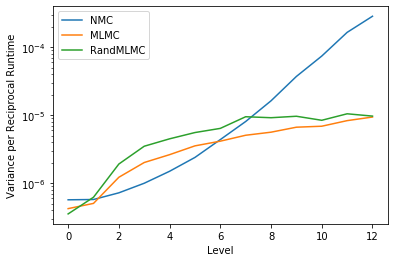

In [41]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel('Variance per Reciprocal Runtime')
plt.yscale('log')

Variance per "reciprocal of the runtime" is considered because the varince is propotional to the  "reciprocal of the runtime". As we increase the computational complexity (runtime), the decrease in varince is inversely propotional to the complexity. 

## Cost comparison of gradients

In [42]:
L = 13
objectives = {
    'NMC':      lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO(x, y, beta0, beta, alpha, mu, sigma, n_MC=2**level),
    'MLMC':     lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=False),
    'RandMLMC': lambda x,y,beta0,beta,alpha,mu,sigma,level: IWELBO_MLMC(x, y, beta0, beta, alpha, mu, sigma, max_level=level, w0=0.90, b=1.8, randomize=True)
}

def d(f):
    # return the derivative of f
    def df(x,y,mu,sigma,level):
        param = tf.concat([beta, [beta0], [alpha]], axis=0)
        param = tf.Variable(param, dtype=tf.float64)
        with tf.GradientTape(persistent=True) as g:
            g.watch(param)
            beta_ = param[:D]
            beta0_ = param[D]
            alpha_ = param[D+1]
            target = f(x,y,beta0_,beta_,alpha_,mu,sigma,level)
        est = g.gradient(target, param)
        return est
    return df

results = {'NMC':[], 'MLMC':[], 'RandMLMC':[]}
runtime = {'NMC':[], 'MLMC':[], 'RandMLMC':[]}

for name, obj in objectives.items():
    
    # evaluate variance
    for i in range(100):
        results[name].append([])
        x,y,_ = generate_data(N=4000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
        mu, sigma = laplace_approx(x, y, beta0, beta, alpha)
        for level in range(L):
            results[name][i].append( d(obj)(x,y,mu,sigma,level).numpy() )
    
    # evaluate runtime
    x,y,_ = generate_data(N=20000, D=3, T=2, beta0=beta0, beta=beta, alpha=alpha)
    mu, sigma = laplace_approx(x, y, beta0, beta, alpha)    
    for level in range(L):
        if level>10 and name=='NMC':
            start = time.time()
            d(obj)(*[vec[:200] for vec in [x,y,mu,sigma]], level)
            end = time.time()
            runtime[name].append((end - start)*100)
        else:
            start = time.time()
            d(obj)(x,y,mu,sigma,level)
            end = time.time()
            runtime[name].append(end - start)

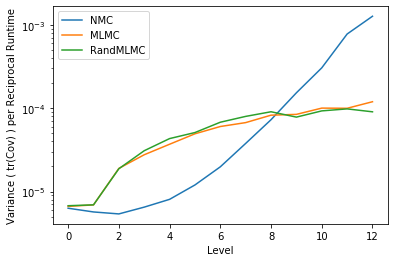

In [43]:
for ests, rtime in zip(results.values(), runtime.values()):
    var_per_recip_runtime = np.array(ests).var(axis=0).sum(axis=1) * np.array(rtime)
    plt.plot(var_per_recip_runtime)
plt.legend([name for name in results.keys()])
plt.xlabel('Level')
plt.ylabel(r'Variance ( tr(Cov) ) per Reciprocal Runtime')
plt.yscale('log')